In [1]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import GridSearchCV, StratifiedKFold  # , cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix  # , classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from scipy import integrate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support,make_scorer
from sklearn.metrics import confusion_matrix

In [2]:
DATA_PATH = '../data/features/disanto'

disantoFeatures = pd.DataFrame()

for i in range(12):
    temp = pd.read_csv(DATA_PATH+'/'+str(i+1)+'.csv')
    disantoFeatures = pd.concat([disantoFeatures,temp])
    

In [3]:
nondisantoFeatures = pd.DataFrame()

for i in range(12):
    temp = pd.read_csv(DATA_PATH+'/Non'+str(i+1)+'.csv')
    nondisantoFeatures = pd.concat([nondisantoFeatures,temp])

In [4]:
allDisanto = pd.concat([disantoFeatures,nondisantoFeatures])

In [5]:
allDisanto.shape

(62152, 37)

In [6]:
allDisanto= allDisanto.set_index(['ID','copy_num'])

In [7]:
feats = np.array(allDisanto.columns[:-2])
print("Total number of features: {}".format(len(feats)))
print()
print("The features are:")
for i,f in enumerate(feats):
    print("    "+str(i+1)+". " + f)


Total number of features: 33

The features are:
    1. skew
    2. std
    3. kurtosis
    4. beyond1st
    5. stetson_j
    6. stetson_k
    7. max_slope
    8. amplitude
    9. median_absolute_deviation
    10. median_buffer_range_percentage
    11. pair_slope_trend
    12. percent_amplitude
    13. percent_difference_flux_percentile
    14. flux_percentile_ratio_mid20
    15. flux_percentile_ratio_mid35
    16. flux_percentile_ratio_mid50
    17. flux_percentile_ratio_mid65
    18. flux_percentile_ratio_mid80
    19. small_kurtosis
    20. pair_slope_trend_last_30
    21. poly1_t1
    22. poly2_t2
    23. poly2_t1
    24. poly3_t3
    25. poly3_t2
    26. poly3_t1
    27. poly4_t4
    28. poly4_t3
    29. poly4_t2
    30. poly4_t1
    31. magnitudeRatio
    32. lombScargle
    33. rcb


In [8]:
allDisanto['binaryClass'] = list(map(lambda x: 0 if x=='non-transient' else 1, allDisanto.Class))

In [9]:
# disantoFeatures = ['amplitude','beyond1st','flux_percentile_ratio_mid20','flux_percentile_ratio_mid35','flux_percentile_ratio_mid50',
#                    'flux_percentile_ratio_mid65','flux_percentile_ratio_mid80','poly1_t1','median_absolute_deviation',
#                    'median_buffer_range_percentage','max_slope','percent_amplitude',
#                    'percent_difference_flux_percentile','pair_slope_trend_last_30','small_kurtosis','skew','std','magnitudeRatio','lombScargle','rcb']
disantoFeatures = feats
for f in disantoFeatures:
    assert f in allDisanto.columns, 'pailas, {} no esta en las cols'.format(f) 

In [10]:
print(disantoFeatures)

['skew' 'std' 'kurtosis' 'beyond1st' 'stetson_j' 'stetson_k' 'max_slope'
 'amplitude' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'percent_amplitude'
 'percent_difference_flux_percentile' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80'
 'small_kurtosis' 'pair_slope_trend_last_30' 'poly1_t1' 'poly2_t2'
 'poly2_t1' 'poly3_t3' 'poly3_t2' 'poly3_t1' 'poly4_t4' 'poly4_t3'
 'poly4_t2' 'poly4_t1' 'magnitudeRatio' 'lombScargle' 'rcb']


In [11]:
set(disantoFeatures) - set(['amplitude','beyond1st','flux_percentile_ratio_mid20','flux_percentile_ratio_mid35','flux_percentile_ratio_mid50',
                   'flux_percentile_ratio_mid65','flux_percentile_ratio_mid80','poly1_t1','median_absolute_deviation',
                   'median_buffer_range_percentage','max_slope','percent_amplitude',
                   'percent_difference_flux_percentile','pair_slope_trend_last_30','small_kurtosis','skew','std','magnitudeRatio','lombScargle','rcb'])

{'kurtosis',
 'pair_slope_trend',
 'poly2_t1',
 'poly2_t2',
 'poly3_t1',
 'poly3_t2',
 'poly3_t3',
 'poly4_t1',
 'poly4_t2',
 'poly4_t3',
 'poly4_t4',
 'stetson_j',
 'stetson_k'}

In [12]:
origtrain = pd.read_pickle('./FixedData/Binary/train.pkl')
origtest = pd.read_pickle('./FixedData/Binary/test.pkl')

In [13]:
train = allDisanto[allDisanto.index.isin(origtrain.index)]
test = allDisanto[allDisanto.index.isin(origtest.index)]

In [14]:
train.shape

(22790, 36)

In [15]:
assert(train.shape[0] == origtrain.shape[0])
assert(test.shape[0] == origtest.shape[0])

# Binary Classification 
Transients and non-transients 

In [16]:
#hypermarameters that gridsearch will optimize
def rf():
    params = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    return RandomForestClassifier(random_state=0, class_weight='balanced'), params

#metrics to be analized
def scorers():
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')
               }
    return scoring

In [17]:
allDisanto.binaryClass.unique()


array([1, 0])

In [18]:
#learning 
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(train[disantoFeatures], train.binaryClass)

# Copy classifier 
clf = grid_search

#see performance on test set
scores = precision_recall_fscore_support(
        test.binaryClass, clf.predict(test[disantoFeatures]), average='weighted')
recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.926), f1_score=(train=1.000, test=0.926), precision=(train=1.000, test=0.926), recall=(train=1.000, test=0.926), total=   8.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.927), f1_score=(train=1.000, test=0.927), precision=(train=1.000, test=0.927), recall=(train=1.000, test=0.927), total=   7.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=(train=1.000, test=0.927), f1_scor

NameError: name 'recall_scores' is not defined

In [19]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_s
                                         coresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

SyntaxError: invalid syntax (<ipython-input-19-48020d7b5e6b>, line 4)

In [20]:
#calculate feature importance in descending order
importances = clf.best_estimator_.feature_importances_*100
featsCopy = disantoFeatures.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))
yx.sort()

yx = yx[::-1]

x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [21]:
importances

array([ 2.91667624,  8.83042986,  1.47219294,  1.3908843 , 16.26081138,
        2.39656684,  1.55190933,  6.60579918,  7.86291143,  2.55838269,
        1.61304611,  1.89263571,  2.34976172,  0.84699944,  0.92519264,
        0.99759801,  0.9759221 ,  0.96959826,  2.00048796,  0.91542242,
        3.38193714,  1.21723656,  3.66954715,  0.38110275,  2.16187176,
        2.67347507,  0.27328559,  0.49337507,  1.9011883 ,  2.55559747,
        5.13257356,  1.74424191,  9.0813391 ])

In [22]:
print(len(disantoFeatures))
print(len(x_sorted))
print(disantoFeatures)

33
33
['skew' 'std' 'kurtosis' 'beyond1st' 'stetson_j' 'stetson_k' 'max_slope'
 'amplitude' 'median_absolute_deviation' 'median_buffer_range_percentage'
 'pair_slope_trend' 'percent_amplitude'
 'percent_difference_flux_percentile' 'flux_percentile_ratio_mid20'
 'flux_percentile_ratio_mid35' 'flux_percentile_ratio_mid50'
 'flux_percentile_ratio_mid65' 'flux_percentile_ratio_mid80'
 'small_kurtosis' 'pair_slope_trend_last_30' 'poly1_t1' 'poly2_t2'
 'poly2_t1' 'poly3_t3' 'poly3_t2' 'poly3_t1' 'poly4_t4' 'poly4_t3'
 'poly4_t2' 'poly4_t1' 'magnitudeRatio' 'lombScargle' 'rcb']


In [23]:
 def shorten(x):
    return {
      'stetson_j':'stetson_j',
      'std':'std',
      'median_absolute_deviation':'mad',
      'amplitude':'amp',
      'poly1_t1':'poly1_t1',
      'poly2_t1':'poly2_t1',
      'skew':'skew',
      'poly3_t1':'poly3_t1',
      'small_kurtosis':'sk',
      'stetson_k':'stetson_k',
      'median_buffer_range_percentage':'mbrp',
      'percent_amplitude': 'p_amp',
      'percent_difference_flux_percentile':'pdfp',
      'poly4_t1':'poly4_t1',
      'poly3_t2':'poly3_t2',
      'poly4_t2':'poly4_t2',
      'max_slope':'max_slope',
      'kurtosis':'kurtosis',
      'pair_slope_trend':'pst',
      'poly2_t2':'poly2_t2',
      'beyond1st':'beyond1st',
      'flux_percentile_ratio_mid35':'fpr35',
      'flux_percentile_ratio_mid50':'fpr50',
      'flux_percentile_ratio_mid65':'fpr65',
      'flux_percentile_ratio_mid20':'fpr20',
      'flux_percentile_ratio_mid80':'fpr80',
      'pair_slope_trend_last_30':'pst_last30',
      'poly3_t3':'poly3_t3',
      'poly4_t3':'poly4_t3',
      'poly4_t4':'poly4_t4',
      'magnitudeRatio':'mr',
      'lombScargle':'ls',
      'rcb':'rcb'
      }[x]

In [24]:
#shorten name length
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

In [25]:
print(len(x_sorted))

33


In [26]:
x_sorted

['stetson_j',
 'rcb',
 'std',
 'mad',
 'amp',
 'mr',
 'poly2_t1',
 'poly1_t1',
 'skew',
 'poly3_t1',
 'mbrp',
 'poly4_t1',
 'stetson_k',
 'pdfp',
 'poly3_t2',
 'sk',
 'poly4_t2',
 'p_amp',
 'ls',
 'pst',
 'max_slope',
 'kurtosis',
 'beyond1st',
 'poly2_t2',
 'fpr50',
 'fpr65',
 'fpr80',
 'fpr35',
 'pst_last30',
 'fpr20',
 'poly4_t3',
 'poly3_t3',
 'poly4_t4']

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


33
33


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


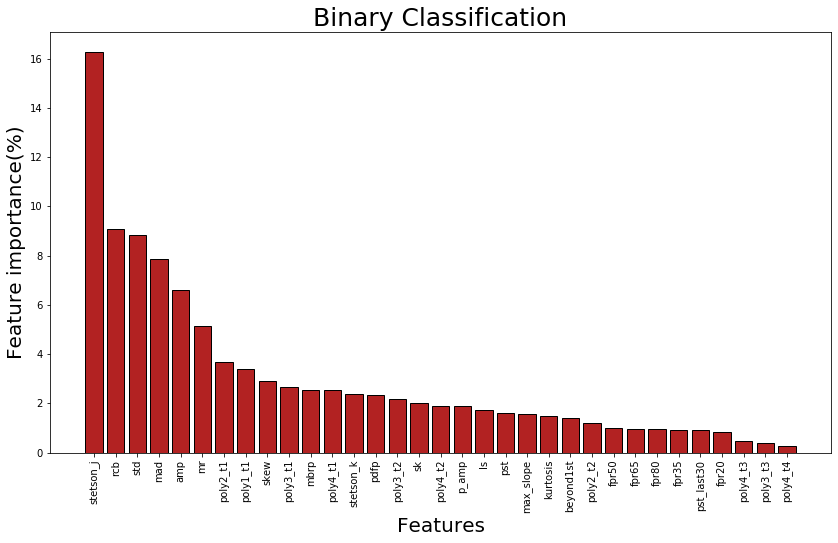

In [27]:

print(len(x_sorted))
print(len(y_sorted))
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='firebrick')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features',fontsize=20)
plt.ylabel('Feature importance(%)',fontsize=20)
plt.title("Binary Classification",fontsize=25)
plt.savefig("../results/binFeatImportanceOurs&Disanto.pdf")

In [28]:
cm = confusion_matrix(test.binaryClass, clf.predict(test[disantoFeatures])).transpose()
cm

array([[3616,  184],
       [ 182,  883]])

In [29]:
def fMeasure(precision,recall):
    return 2*precision*recall/(precision+recall)

In [30]:
precisionNon = cm[0][0]/(cm[0][0]+cm[0][1])
recallNon = cm[0][0]/(cm[0][0]+cm[1][0])
precisionT = cm[1][1]/(cm[1][1]+cm[1][0])
recallT = cm[1][1]/(cm[1][1]+cm[0][1])

In [31]:
print("Precision of transients:     {:.4f}".format(precisionT))
print("Recall of transients:        {:.4f}".format(recallT))
print("F-measure of transients:     {:.4f}".format(fMeasure(precisionT,recallT)))
print("Precision of non-transients: {:.4f}".format(precisionNon))
print("Recall of non-transients:    {:.4f}".format(recallNon))
print("F-measure of non-transients: {:.4f}".format(fMeasure(precisionNon,recallNon)))


Precision of transients:     0.8291
Recall of transients:        0.8276
F-measure of transients:     0.8283
Precision of non-transients: 0.9516
Recall of non-transients:    0.9521
F-measure of non-transients: 0.9518


# 8-Class clasification

In [37]:
np.random.seed(0)

In [38]:
# main 6 transient classes
labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare']


In [39]:
# func to map labels to integer values
def manualFact(lab):
    labels = ['SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient']
    return labels.index(lab)

In [40]:
origTrain = pd.read_pickle('./FixedData/8Class/train.pkl')
origTest = pd.read_pickle('./FixedData/8Class/test.pkl')

In [41]:
train = origTrain[['target']].merge(allDisanto, left_index=True, right_index=True)
test = origTest[['target']].merge(allDisanto, left_index=True, right_index=True)


In [42]:
assert(train.shape[0] == origTrain.shape[0])
assert(test.shape[0] == origTest.shape[0])

In [43]:
recall_scores = []
model,params = rf()
grid_search = GridSearchCV(model, params, cv=StratifiedKFold(2), scoring=scorers(),
                           refit='f1_score', return_train_score=True,verbose=100)
grid_search.fit(train[disantoFeatures], train.target)
# Copy classifier
clf = grid_search

scores = precision_recall_fscore_support(
        test.target, clf.predict(test[disantoFeatures]), average='weighted')


recall_scores.append(scores)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.776), f1_score=(train=1.000, test=0.775), precision=(train=1.000, test=0.775), recall=(train=1.000, test=0.776), total=   5.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[CV] max_features=auto, n_estimators=200 .............................
[CV]  max_features=auto, n_estimators=200, accuracy=(train=1.000, test=0.786), f1_score=(train=1.000, test=0.784), precision=(train=1.000, test=0.784), recall=(train=1.000, test=0.786), total=   5.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV]  max_features=auto, n_estimators=700, accuracy=(train=1.000, test=0.781), f1_scor

In [44]:
recall_scoresnp = np.array(recall_scores)

print("Precision: {:.4f}".format(np.mean(recall_scoresnp[:,0])))
print("Recall:    {:.4f}".format(np.mean(recall_scoresnp[:,1])))
print("F-score:   {:.4f}".format(np.mean(recall_scoresnp[:,2])))

Precision: 0.8630
Recall:    0.7742
F-score:   0.8085


In [45]:
confMatr = confusion_matrix(test.target, clf.predict(test[disantoFeatures])).transpose()
print(confMatr)
# 'SN', 'CV', 'AGN', 'HPM', 'Blazar', 'Flare','Other','non-transient'

[[ 164   20    0    0    8    7   34   91]
 [  19  166    0    1    7    1   15   31]
 [   3    2   94    0    9    1   31   36]
 [   5    0    0   67    0    1    3  117]
 [   8    5    1    0   27    0   10    4]
 [  21    5    1    0    2   23    6  282]
 [  57   13    9    1    4    5  115  129]
 [  46    4    1    7    2   13   20 3108]]


In [46]:
normedMatrix = confMatr.copy()
# print(normedMatrix)
for i in range(len(normedMatrix)):
#     print(normedMatrix[:,i]/normedMatrix[:,i].sum())
    normedMatrix[:,i] = normedMatrix[:,i]/normedMatrix[:,i].sum()
#     print(normedMatrix[:,i])
# np.set_printoptions(suppress=True)
print(normedMatrix)
# np.set_printoptions(suppress=False)

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [47]:
newMatr = []
for i in range(len(confMatr)):
    prec = confMatr[i][i]/(sum(confMatr[i,:]))
    rec = confMatr[i][i]/(sum(confMatr[:,i]))
    newMatr.append([prec,rec,fMeasure(prec,rec),sum(confMatr[:,i])])

In [48]:
np.set_printoptions(suppress=True)
print('    Precision        Recall         F-score      Cover')
print(np.array(newMatr))
np.set_printoptions(suppress=False)

    Precision        Recall         F-score      Cover
[[   0.50617284    0.50773994    0.50695518  323.        ]
 [   0.69166667    0.77209302    0.72967033  215.        ]
 [   0.53409091    0.88679245    0.66666667  106.        ]
 [   0.34715026    0.88157895    0.49814126   76.        ]
 [   0.49090909    0.45762712    0.47368421   59.        ]
 [   0.06764706    0.45098039    0.11764706   51.        ]
 [   0.34534535    0.49145299    0.40564374  234.        ]
 [   0.97094658    0.81832543    0.88812688 3798.        ]]


In [49]:
importances = clf.best_estimator_.feature_importances_*100
featsCopy = disantoFeatures.copy()

Y = list(importances)
X = list(featsCopy)

yx = list(zip(Y, X))

yx.sort()
# yx = yx[::-1]
yx = yx[::-1]



x_sorted = [x for y, x in yx]
y_sorted = [y for y, x in yx]


In [50]:
for i,x in enumerate(x_sorted):
    x_sorted[i]=shorten(x)

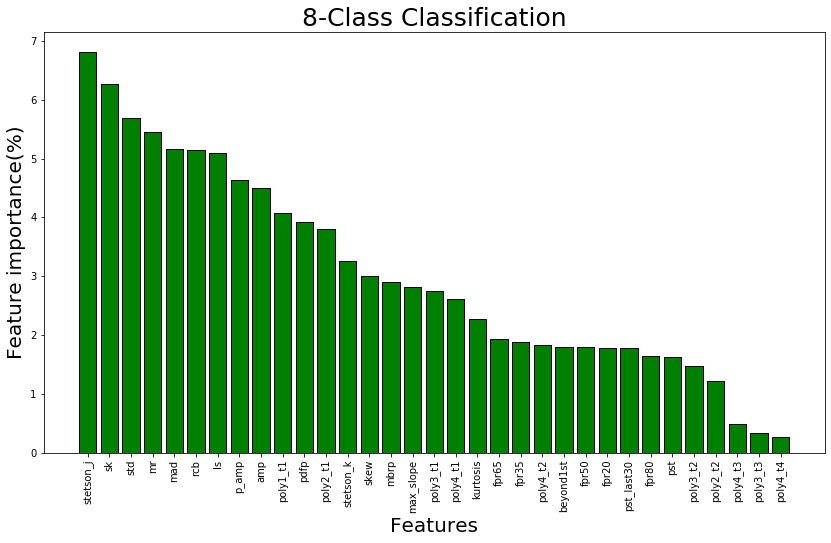

In [51]:
# from matplotlib.font_manager import FontProperties
# font = FontProperties()
# font.set_family('sans-serif')
# font.set_style('normal')

plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(14,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.bar(np.arange(len(y_sorted)), y_sorted,edgecolor='black',color='#008000')
plt.xticks(np.arange(len(y_sorted)), x_sorted,rotation='vertical')
plt.xlabel('Features',fontsize=20)
plt.ylabel('Feature importance(%)',fontsize=20)
plt.title("8-Class Classification",fontsize=25)
plt.savefig("../results/8clasFeatImportanceOurs&Disanto.pdf")